# water properties worldwide: compressibility, thermal expansion ...

In [81]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pyn
crs = pyn.maps.crs

import gsw
from freshwater.eos import Eos

--- 
## global perspective

In [205]:
files_woa = ['woa18_A5B7_t00_01.nc','woa18_A5B7_s00_01.nc']
woa = xr.merge([xr.open_dataset(f, decode_times=False) for f in files_woa]).isel(time=0)
#print(woa)

t, s, lon, lat, p = xr.broadcast(woa.t_an, woa.s_an, woa.lon, woa.lat, woa.depth)
ds = xr.merge([t.rename("t"), s.rename("s"), p.rename("p")])
ds["bathy_depth"] = ((~np.isnan(ds.t))*ds.depth).max("depth")

In [206]:
ds["SA"] = gsw.SA_from_SP(ds["s"], ds["p"], ds.lon, ds.lat)
ds["CT"] = gsw.CT_from_t(ds["SA"], ds["t"], ds["p"])

ds["kappa"] = gsw.kappa(ds.SA, ds.CT, ds.p) # isentropic compressibility of seawater 1/Pa
ds["alpha"] = gsw.alpha(ds.SA, ds.CT, ds.p)
ds["beta"] = gsw.beta(ds.SA, ds.CT, ds.p)
ds["rho"] = gsw.rho(ds.SA, ds.CT, ds.p)

ds["dt_dz"] = (
    (ds["t"].shift(depth=1)-ds["t"].shift(depth=-1))
    /(ds["depth"].shift(depth=1)-ds["depth"].shift(depth=-1))
)

ds["N2_mid"] = xr.DataArray(
    N2, 
    dims=("depth_m", "lat", "lon"), 
    #coords=dict(depth_mid=(("depth_m", "lat", "lon"), depth_mid)),
    coords=dict(depth_m=(("depth_m",), depth_mid[:,0,0])),
)
ds["N2"] = ds["N2_mid"].interp(depth_m=ds.depth)


Text(0.5, 1.0, 'kappa')

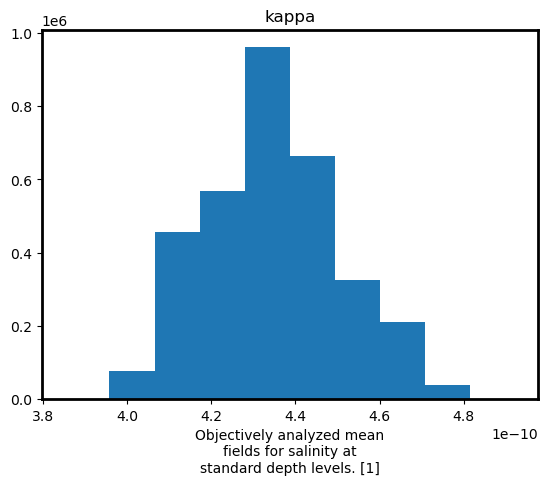

In [158]:
fig, ax = plt.subplots(1,1)
ds.kappa.plot.hist(ax=ax)
ax.set_title("kappa")

Text(0.5, 1.0, 'density')

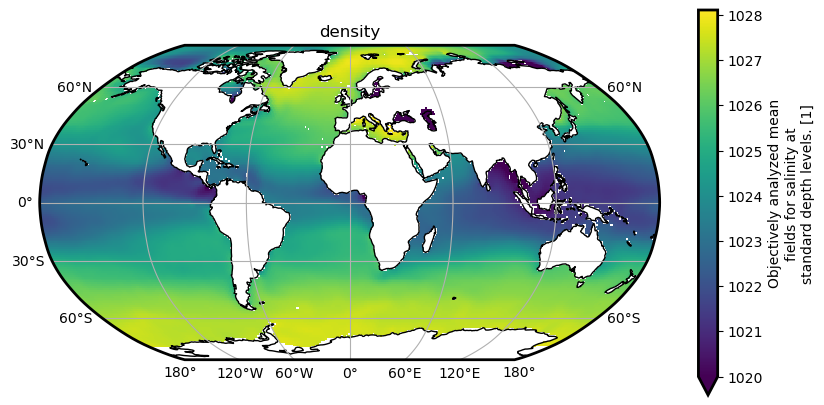

In [137]:
fig, ax, _ = pyn.maps.plot_map(figsize=(10,5))
ds.rho.sel(depth=10).plot(ax=ax, vmin=1020, transform=crs)
ax.set_title("density")

Text(0.5, 1.0, 'temperature')

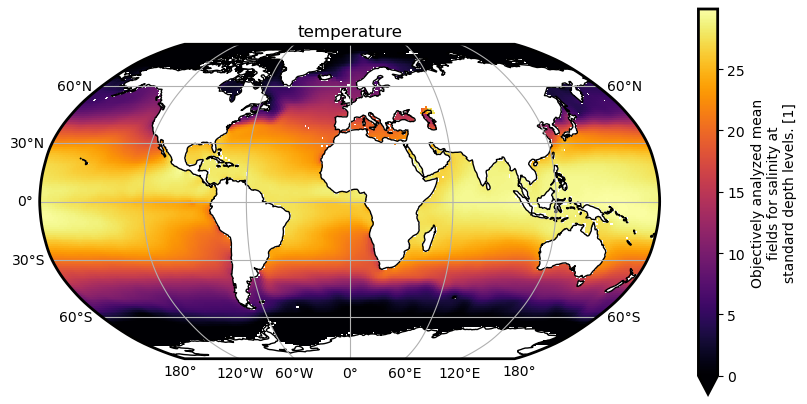

In [140]:
fig, ax, _ = pyn.maps.plot_map(figsize=(10,5))
ds.CT.sel(depth=10).plot(ax=ax, vmin=0, transform=crs, cmap="inferno")
ax.set_title("temperature")

In [142]:
from cmocean import cm

Text(0.5, 1.0, 'salinity')

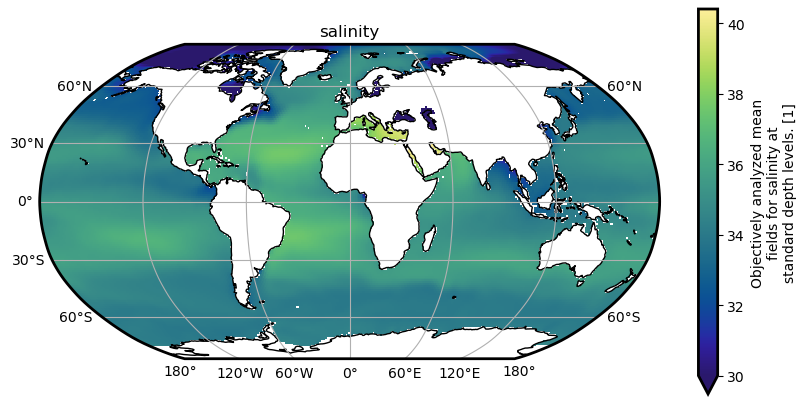

In [144]:
fig, ax, _ = pyn.maps.plot_map(figsize=(10,5))
ds.SA.sel(depth=10).plot(ax=ax, vmin=30, transform=crs, cmap=cm.haline)
ax.set_title("salinity")

Text(0.5, 1.0, 'kappa')

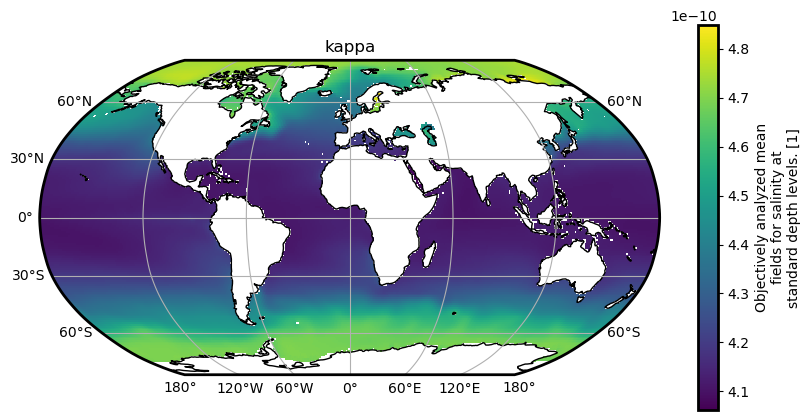

In [160]:
fig, ax, _ = pyn.maps.plot_map(figsize=(10,5))
ds.kappa.sel(depth=10).plot(ax=ax, transform=crs)
ax.set_title("kappa")

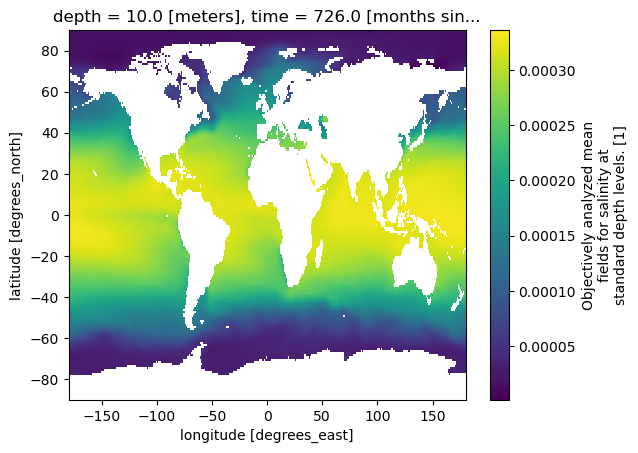

In [57]:
ds.alpha.sel(depth=10).plot()

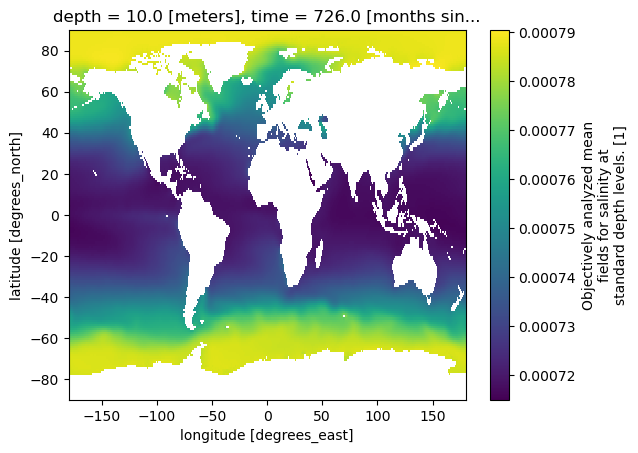

In [58]:
ds.beta.sel(depth=10).plot()

Text(0.5, 1.0, 'density')

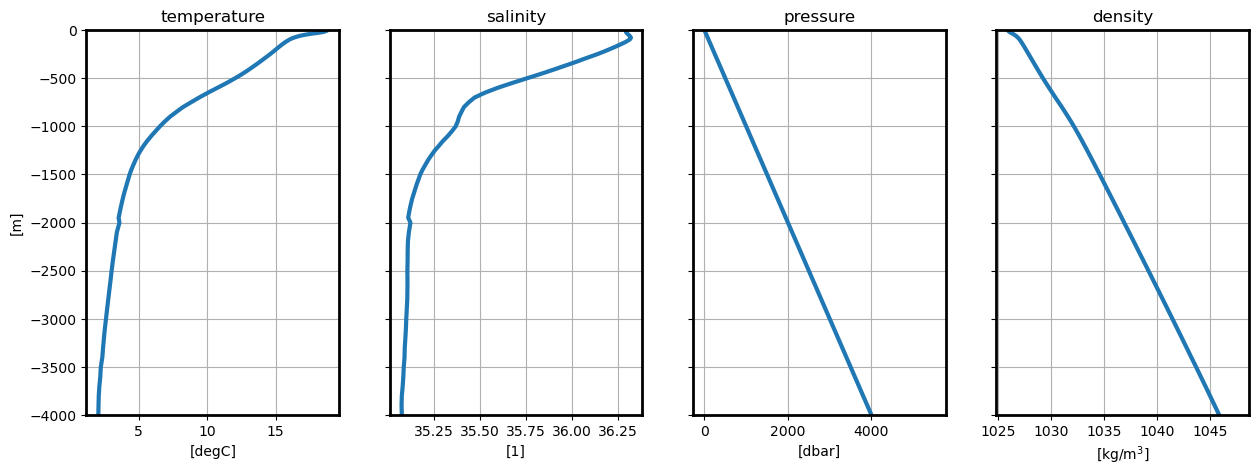

In [132]:
_ds = ds.sel(lon=-35, lat=40, method='nearest')
#_ds = _ds.where(_ds.bathy_depth>1500)

fig, axes = plt.subplots(1,4, figsize=(15,5), sharey=True) #, gridspec_kw=dict(wspace=.4))

ax = axes[0]
ax.plot(_ds.CT, -_ds.depth,lw=3);
ax.grid()
ax.set_xlabel(r"[degC]")
ax.set_ylabel(r"[m]")
ax.set_ylim(-4000,0)
ax.set_title("temperature")

ax = axes[1]
ax.plot(_ds.SA, -_ds.depth, lw=3);
ax.grid()
ax.set_xlabel(r"[1]")
ax.set_title("salinity")

ax = axes[2]
ax.plot(_ds.depth, -_ds.depth, lw=3);
ax.grid()
ax.set_xlabel(r"[dbar]")
ax.set_title("pressure")

ax = axes[3]
ax.plot(_ds.rho, -_ds.depth, lw=3);
ax.grid()
ax.set_xlabel(r"[kg/m$^3$]")
ax.set_title("density")

 kappa = 4.30e-10 1/Pa
 kappa = 4.36e-06 1/dbar


Text(0, 0.5, '[m]')

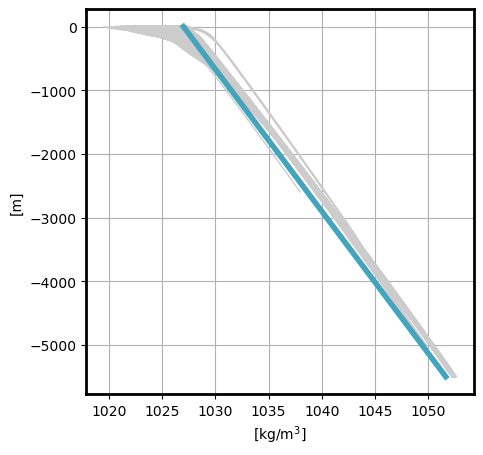

In [157]:
_ds = ds.sel(lat=slice(-60,60))
_ds = _ds.isel(lon=slice(0,None,4),lat=slice(0,None,4))
_ds = _ds.stack(point=("lon","lat"))
_ds = _ds.where(_ds.bathy_depth>1500)

fig, ax = plt.subplots(1,1, figsize=(5,5))

_ds = _ds.where(_ds.rho.sel(depth=0.)>1015)
ax.plot(_ds.rho, _ds.rho*0. -_ds.depth, color="0.8", lw=1);

dp_dz = 9.81*_ds.rho.mean() # F/L^2 = kg*L/T^2/L^2
kappa = _ds.kappa.mean()
ax.plot( 1027 * (1 + _ds.depth*dp_dz*_ds.kappa.mean()) , -_ds.depth, color=(67/256, 165/256, 188/256), lw=4);

print(f" kappa = {kappa:.2e} 1/Pa")
print(f" kappa = {kappa*dp_dz:.2e} 1/dbar")

ax.grid()
ax.set_xlabel(r"[kg/m$^3$]")
ax.set_ylabel(r"[m]")

In [219]:
gamma_f

3e-10

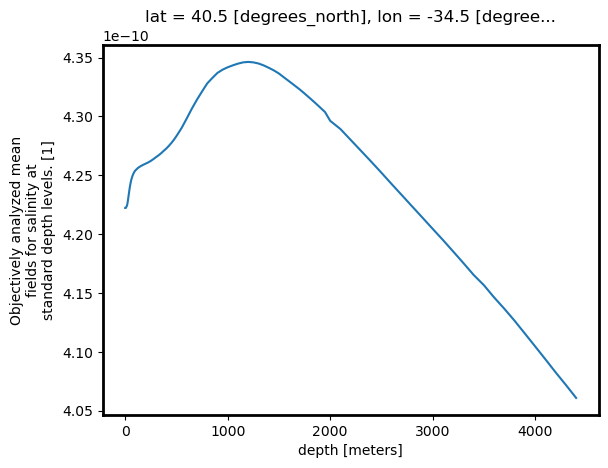

In [222]:
_ds.kappa.plot()

In [ ]:
9.81*1e-10

Text(0.5, 1.0, 'density')

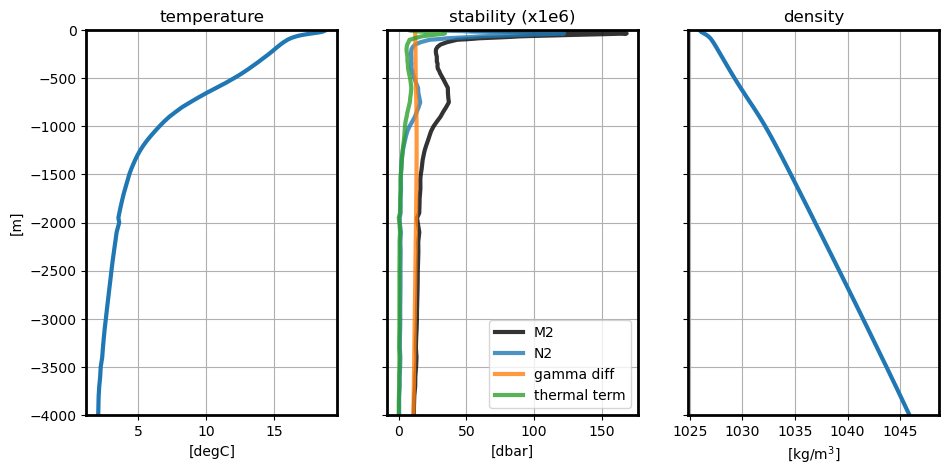

In [231]:
# local stability
g = 9.81

gamma_f = 3e-10 # 1/Pa
alpha_f = 7e-5 # 1/degC

_ds = ds.sel(lon=-35, lat=40, method='nearest')
#_ds = _ds.where(_ds.bathy_depth>1500)

fig, axes = plt.subplots(1,3, figsize=(11,5), sharey=True) #, gridspec_kw=dict(wspace=.4))

ax = axes[0]
ax.plot(_ds.CT, -_ds.depth,lw=3);
ax.grid()
ax.set_xlabel(r"[degC]")
ax.set_ylabel(r"[m]")
ax.set_ylim(-4000,0)
ax.set_title("temperature")

ax = axes[1]

M2_0 = _ds.N2
M2_1 = g*(_ds.kappa - gamma_f)*1e4
M2_2 = -g * alpha_f * _ds.dt_dz
M2 = M2_0 + M2_1 + M2_2

sc = 1e6
a = .8

ax.plot(M2*sc, -_ds.depth, lw=3, color="k", label="M2", alpha=a);
ax.plot(M2_0*sc, -_ds.depth, lw=3, label="N2", alpha=a);
ax.plot(M2_1*sc, -_ds.depth, lw=3, label="gamma diff", alpha=a);
ax.plot(M2_2*sc, -_ds.depth, lw=3, label="thermal term", alpha=a);
ax.grid()
ax.legend()
ax.set_xlabel(r"[dbar]")
ax.set_title("stability (x1e6)")
#ax.set_xlim(-1,5)

ax = axes[2]
ax.plot(_ds.rho, -_ds.depth, lw=3);
ax.grid()
ax.set_xlabel(r"[kg/m$^3$]")
ax.set_title("density")

In [232]:
woa = ds

---

## regional perspective

In [36]:
import argopy

In [62]:
extent = [-37, -20, 35, 45]

In [40]:
# load ARGO profiles
f = argopy.DataFetcher().region(extent + [0, 10_000, '2023-01', '2024-01'])
ds = f.data
ds.argo.teos10(['SA', 'CT',])
ds["rho"] = ds["rho"] = gsw.rho(ds.SA, ds.CT, ds.PRES)
ds_pr = ds.argo.point2profile()

(<Figure size 900x540 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

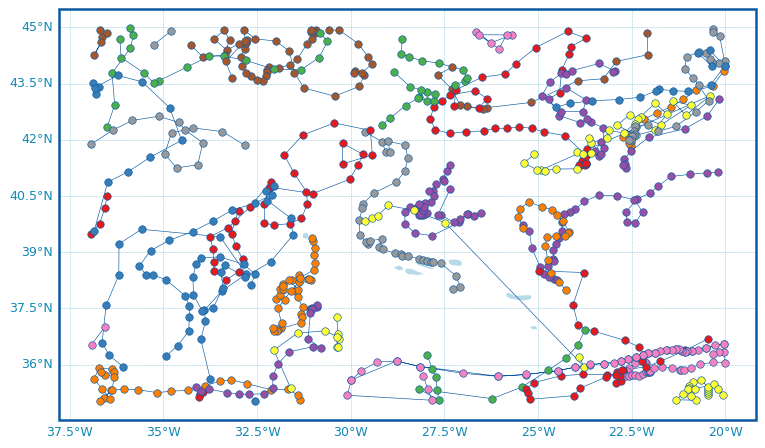

In [82]:
f.plot('trajectory', add_legend=False)

Text(0.5, 1.0, '')

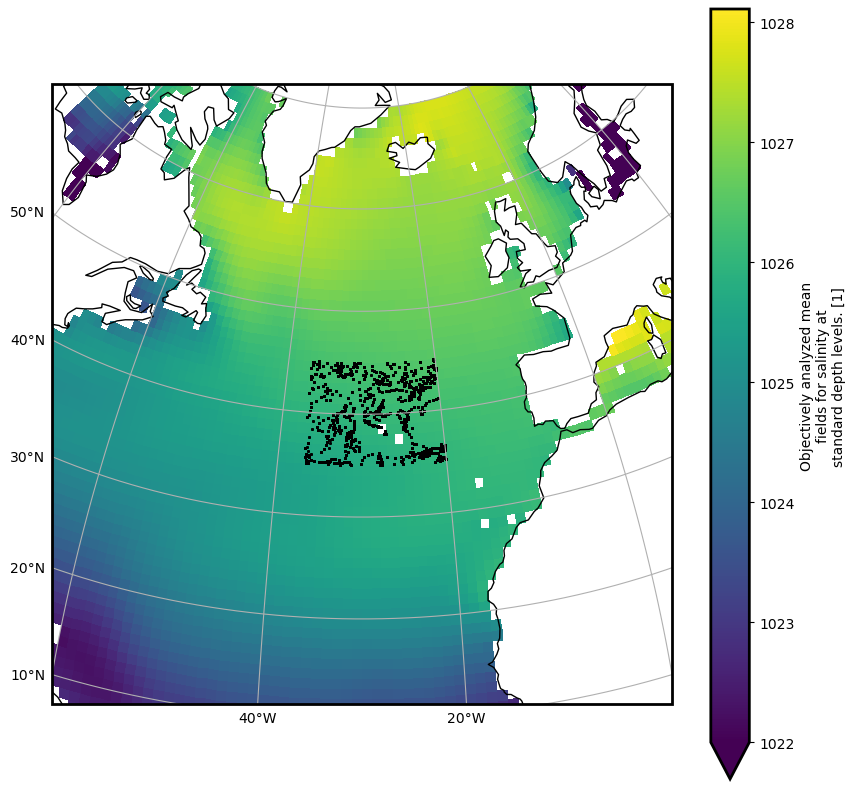

In [104]:
#extent=[-50, 0, 0, 60]
_ext = [-60, 0, 10, 70]

fig, ax, _ = pyn.maps.plot_map(extent=_ext, figsize=(10,10))

woa.sel(lon=slice(_ext[0]-30,_ext[1]+30), lat=slice(_ext[2]-10,_ext[3]), depth=10).rho.plot(ax=ax, x="lon", y="lat", transform=crs, vmin=1022)

ax.scatter(ds.LONGITUDE, ds.LATITUDE, c="k", s=.1, transform=crs)
ax.set_title("")

 kappa = 4.27e-10 1/Pa
 kappa = 4.33e-06 1/dbar


Text(0, 0.5, '[m]')

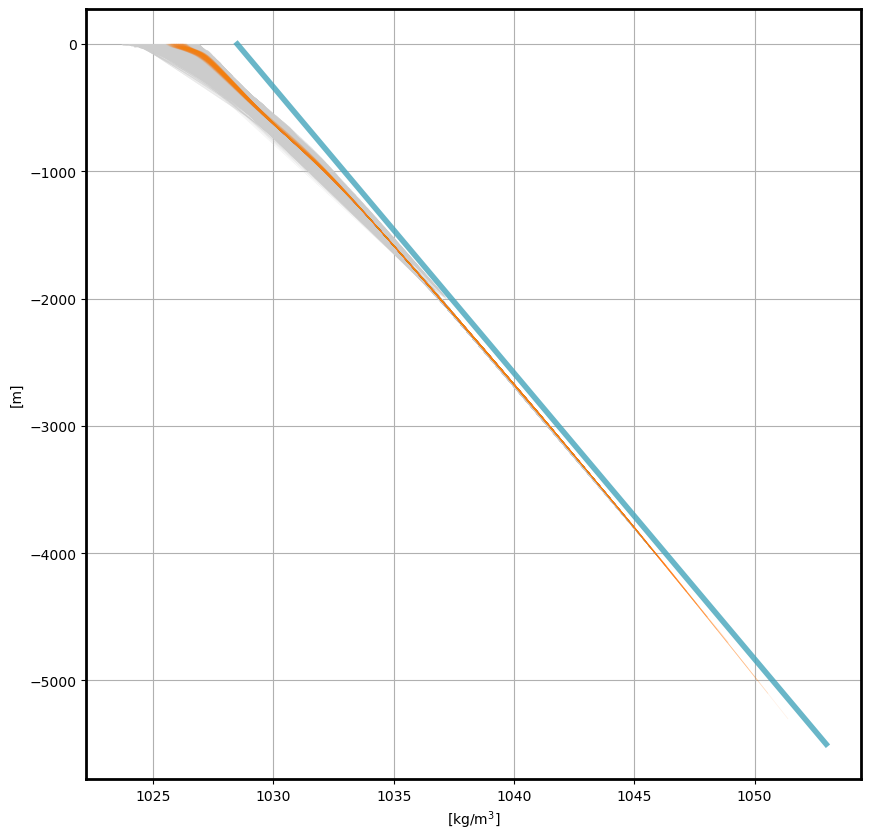

In [165]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(ds_pr["rho"], -ds_pr.PRES, color="0.8", lw=.1, label="argo");

_ds = woa.sel(lon=slice(extent[0], extent[1]), lat=slice(extent[2], extent[3])).stack(point=["lon", "lat"])
ax.plot(_ds["rho"], _ds.rho*0. -_ds.depth, color="C1", lw=.5, alpha=.1, label="woa");

dp_dz = 9.81*ds.rho.mean() # F/L^2 = kg*L/T^2/L^2
kappa = _ds.kappa.mean()
ax.plot( 1028.5 * (1 + _ds.depth*dp_dz*kappa) , -_ds.depth, color=(67/256, 165/256, 188/256), lw=4, alpha=0.8);

print(f" kappa = {kappa:.2e} 1/Pa")
print(f" kappa = {kappa*dp_dz:.2e} 1/dbar")


ax.grid()
ax.set_xlabel(r"[kg/m$^3$]")
ax.set_ylabel(r"[m]")
#ax.legend(loc=0)

---
## fresh vs salty water equation of state


https://en.wikipedia.org/wiki/Speed_of_sound

In [14]:
t, s, p = 12, .5, 1
e = Eos(12, s=0.5, p=1+p/10)
c2gamma = lambda e: 1/e.u**2/e.rho*1e4 # 1/dbar
gamma = c2gamma(e)
e.rho, e.alpha, gamma

(999.938992100746, 0.00011564965786311998, 4.718607343187234e-06)

In [15]:
import gsw
SA = gsw.SA_from_SP(s, p, -30, 45)
CT = gsw.CT_from_t(SA, t, p)
gsw.rho(SA, CT, p), gsw.alpha(SA, CT, p), gsw.kappa(SA, CT, p)*1e4, SA, CT

(999.8962253600038,
 0.00010984986572147331,
 4.719836087086292e-06,
 0.502362924538354,
 12.642951683339234)

Text(0.5, 0, 'temperature [degC]')

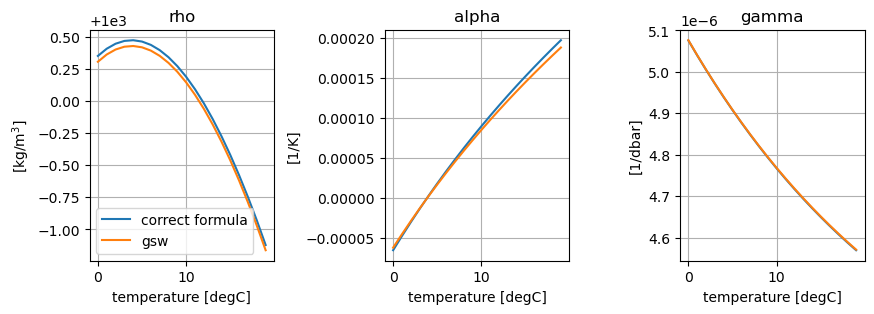

In [32]:
s, p = .5, 10
t = np.arange(0,20)

e = Eos(t, s=0.5, p=1+p/10)
gamma = c2gamma(e)

SA = gsw.SA_from_SP(s, p, -30, 45)
CT = gsw.CT_from_t(SA, t, p)
rho_gsw = gsw.rho(SA, CT, p)
alpha_gsw = gsw.alpha(SA, CT, p)
gamma_gsw = gsw.kappa(SA, CT, p)*1e4

fig, axes = plt.subplots(1,3, figsize=(10,3), gridspec_kw=dict(wspace=.6))
ax = axes[0]
ax.plot(t, e.rho, label="correct formula")
ax.plot(t, rho_gsw, label="gsw")
ax.legend()
ax.grid()
ax.set_title("rho")
ax.set_ylabel(r"[kg/m$^3$]")
ax.set_xlabel("temperature [degC]")

ax = axes[1]
ax.plot(t, e.alpha, label="correct formula")
ax.plot(t, alpha_gsw, label="gsw")
#ax.legend()
ax.grid()
ax.set_title("alpha")
ax.set_ylabel("[1/K]")
ax.set_xlabel("temperature [degC]")

ax = axes[2]
ax.plot(t, gamma, label="correct formula")
ax.plot(t, gamma_gsw, label="gsw")
#ax.legend()
ax.grid()
ax.set_title("gamma")
ax.set_ylabel("[1/dbar]")
ax.set_xlabel("temperature [degC]")

Text(0.5, 0, 'pressure [dbar]')

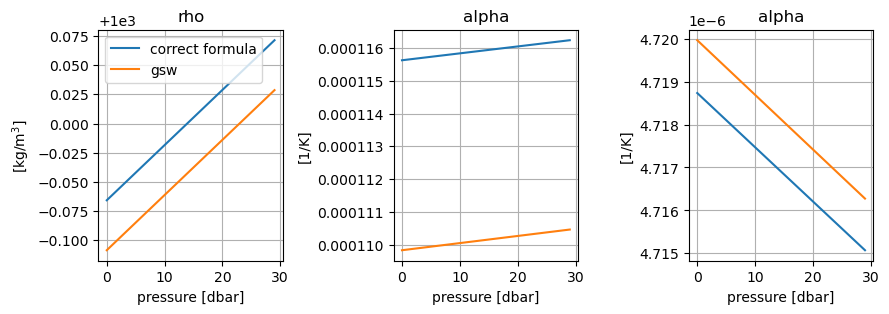

In [35]:
s, p = .5, np.arange(0,30)
t = 12

e = Eos(t, s=0.5, p=1+p/10)
gamma = c2gamma(e)

SA = gsw.SA_from_SP(s, p, -30, 45)
CT = gsw.CT_from_t(SA, t, p)
rho_gsw = gsw.rho(SA, CT, p)
alpha_gsw = gsw.alpha(SA, CT, p)
gamma_gsw = gsw.kappa(SA, CT, p)*1e4

fig, axes = plt.subplots(1,3, figsize=(10,3), gridspec_kw=dict(wspace=.6))
ax = axes[0]
ax.plot(p, e.rho, label="correct formula")
ax.plot(p, rho_gsw, label="gsw")
ax.legend()
ax.grid()
ax.set_title("rho")
ax.set_ylabel(r"[kg/m$^3$]")
ax.set_xlabel("pressure [dbar]")

ax = axes[1]
ax.plot(p, e.alpha, label="correct formula")
ax.plot(p, alpha_gsw, label="gsw")
#ax.legend()
ax.grid()
ax.set_title("alpha")
ax.set_ylabel("[1/K]")
ax.set_xlabel("pressure [dbar]")

ax = axes[2]
ax.plot(p, gamma, label="correct formula")
ax.plot(p, gamma_gsw, label="gsw")
#ax.legend()
ax.grid()
ax.set_title("alpha")
ax.set_ylabel("[1/K]")
ax.set_xlabel("pressure [dbar]")

